In [73]:
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

# Data split

In [74]:
data_X, data_Y = make_regression(n_samples=150000, n_features=10, n_informative=10, n_targets=1, bias=0.0, effective_rank=None, tail_strength=0.5, noise=0.0, shuffle=True, coef=False, random_state=None)

In [75]:
N_FEATURES = data_X.shape[1]

In [76]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size=0.2)

In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [78]:
train_X = torch.from_numpy(train_X)
test_X = torch.from_numpy(test_X)
train_Y = torch.from_numpy(train_Y)
test_Y = torch.from_numpy(test_Y)

In [79]:
class DatasetCustom(torch.utils.data.Dataset):
    
    def __init__(self, data_X, data_Y):
        self.data_X = data_X.float()
        self.data_Y = data_Y.reshape(-1, 1).float()
        
    def __len__(self):
        return len(self.data_Y)
    
    def __getitem__(self, index):
            
        return self.data_X[index], self.data_Y[index]

In [80]:
train_loader = torch.utils.data.DataLoader(
    DatasetCustom(train_X, train_Y),
    batch_size=128,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    DatasetCustom(test_X, test_Y),
    batch_size=128,
    shuffle=True
)

# LR

In [81]:
lr = LinearRegression()

In [82]:
lr = lr.fit(train_X, train_Y)

In [83]:
train_prediction = lr.predict(train_X)
print(mean_squared_error(train_prediction, train_Y))

4.343834333725762e-26


In [84]:
test_prediction = lr.predict(test_X)
print(mean_squared_error(test_prediction, test_Y))

4.32888058030306e-26


# DNN preparation

In [85]:
def compute_loss(model, loader, loss):
    model.eval()
    loss_accum = 0
    for i_step, (x, y) in enumerate(loader):
            x_gpu = x.type(torch.cuda.FloatTensor).to(device)
            y_gpu = y.type(torch.cuda.FloatTensor).to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)            
            loss_accum += loss_value
            
    return loss_accum / (i_step + 1)


def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0
        for i_step, (x, y) in enumerate(train_loader):
            x_gpu = x.type(torch.cuda.FloatTensor).to(device)
            y_gpu = y.type(torch.cuda.FloatTensor).to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        val_loss = compute_loss(model, val_loader, loss)
        train_history.append(float(ave_loss))
        val_history.append(float(val_loss))
        
#         print("Train loss: %f, Val loss: %f" % (ave_loss, val_loss))
        
    return train_history, val_history

# DNN modeling

In [90]:
def weight_reset(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

def make_combination(model, optimizer_class, lr_value, eval_id):
    
    num_epochs = 10
    
    model.apply(weight_reset)
    loss_func = nn.MSELoss().type(torch.cuda.FloatTensor).to(device)
    optimizer = optimizer_class(model.parameters(), lr=lr_value)
    train_history, test_history = train_model(model, train_loader, test_loader, loss_func, optimizer, num_epochs)
    
    x_values = np.linspace(0, num_epochs, num_epochs)
    
    plt.plot(x_values, train_history, label='train loss')
    plt.plot(x_values, test_history, label='test loss')
    plt.title(f"{eval_id} plot")
    plt.legend()
    plt.show()



In [87]:
def list_to_dnn(layers_list):
    layers = []
    last = N_FEATURES
    
    for number in layers_list:
        layers.extend((
            nn.Linear(last, number),
            nn.BatchNorm1d(number),
            nn.ReLU(inplace=True),
        ))
        last = number
    layers.append(
        nn.Linear(last, 1)
    )
    model = nn.Sequential(*layers)
    model.type(torch.cuda.FloatTensor)
    model.to(device)
    return model

In [88]:
dnn_1 = [10]
dnn_2 = [10, 20, 30, 20, 10]
dnn_3 = dnn_2 * 4 + dnn_1 * 5

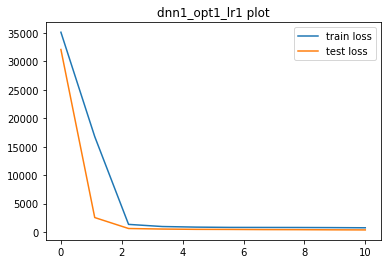

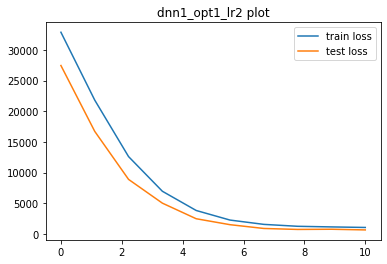

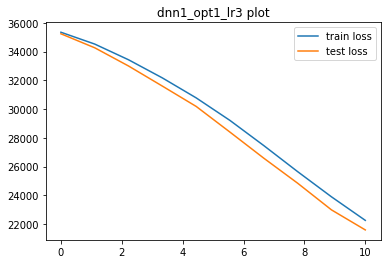

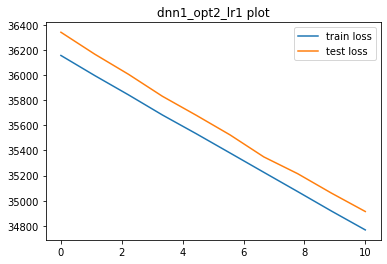

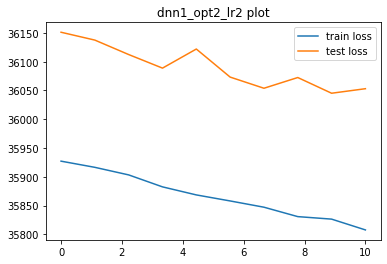

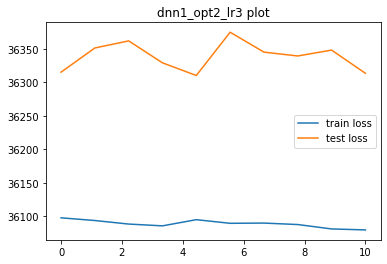

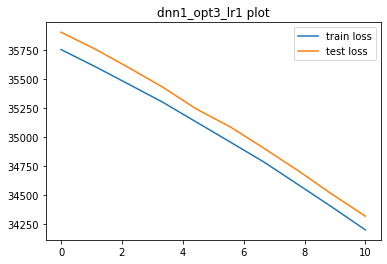

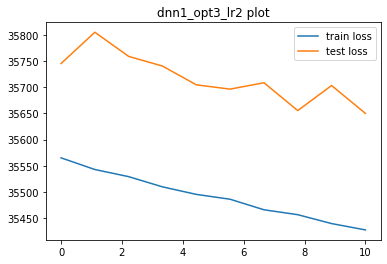

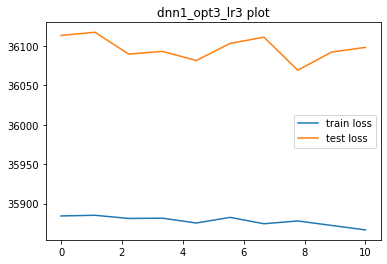

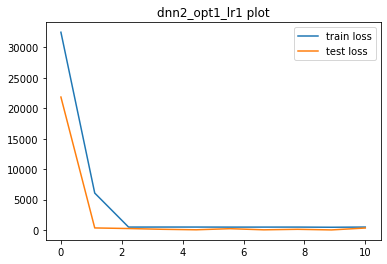

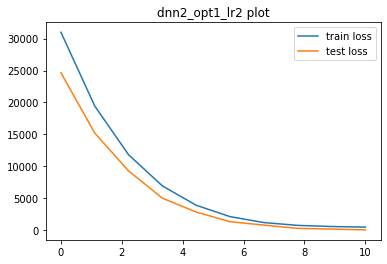

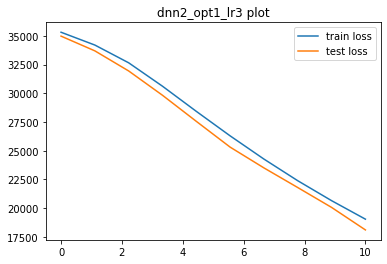

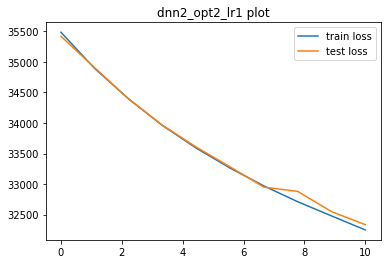

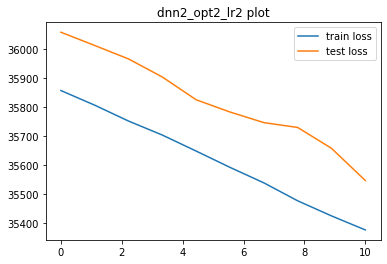

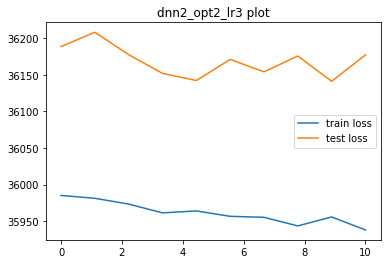

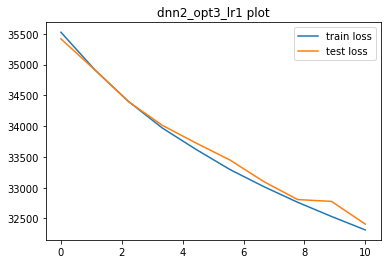

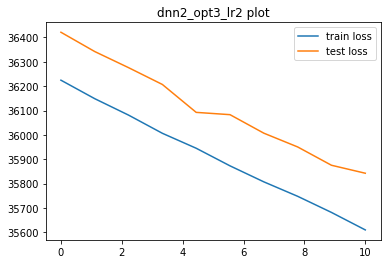

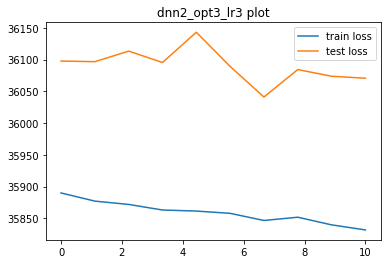

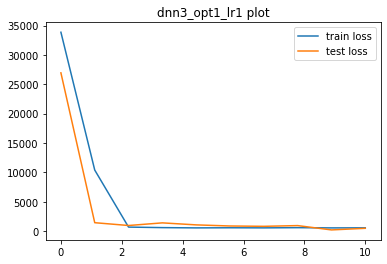

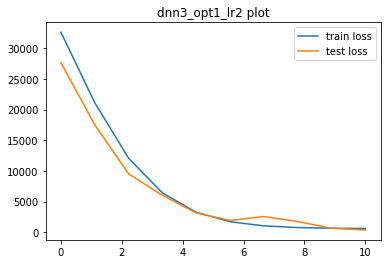

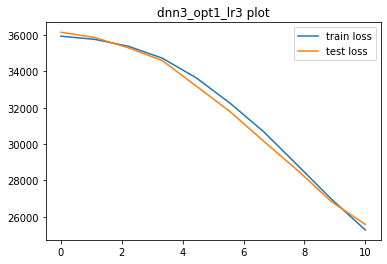

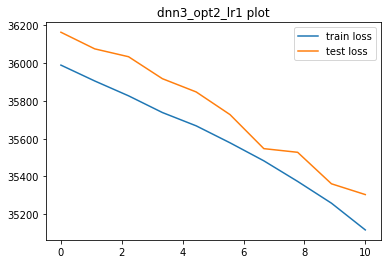

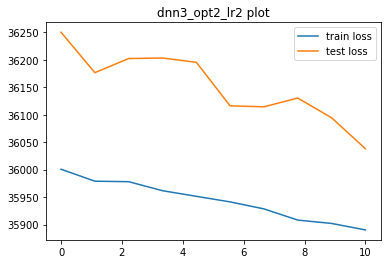

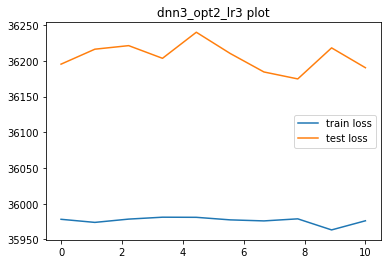

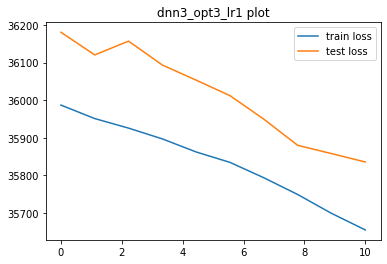

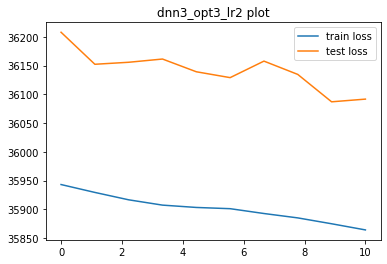

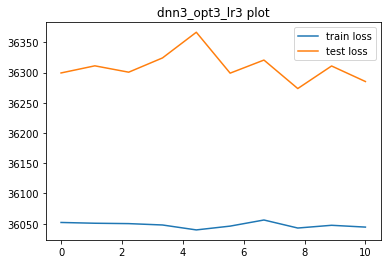

In [91]:
DNNS = (
    list_to_dnn(dnn_1),
    list_to_dnn(dnn_2),
    list_to_dnn(dnn_3),
)
OPTS = (
    optim.SGD,
    optim.RMSprop,
    optim.Adam,
)
LRS = (
    1e-5,
    1e-6,
    1e-7,
)

for dnn_i, dnn in enumerate(DNNS):
    for opt_i, opt in enumerate(OPTS):
        for lr_i, lr in enumerate(LRS):
            make_combination(dnn, opt, lr, f"dnn{dnn_i+1}_opt{opt_i+1}_lr{lr_i+1}")